# Big Data with H2O - Regression

### 1. Packages and Setup 
#### Import packages and dataset

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

#### Set up some paramaters

In [2]:
data_Path = None
model_Path = None
report_Path = None

min_mem_size = 6
run_time = 333
nthreads = 1 

name = 'Binary_classification'
target = None
classification = True
max_models = 9

### 2. Helper functions

In [3]:
# generate run_id
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

In [4]:
# save dictionary to json file
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [5]:
# function to set the meta_data
def set_meta_data(run_id,target,model,run_time,classification,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['classification']=classification
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    return m_data

In [6]:
# get all variables and its tpye
def get_variables_types(df):
    '''
    param: 
    df: Dateset dataframe
    
    return:
    Dictionary of all variables and its type
    '''
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

In [7]:
# get the best model for different type
def stackedensemble_df(df):
    '''
    param: 
    df: AutoML leaderboard dataframe
    
    return:
    List of best models' id
    '''
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
        if key in bm_algo:
            if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

In [8]:
# get the best stacked_ensemble model
def get_stacked_ensemble(model_set):
    '''
    param: 
    model_set: List of all models' name
    
    return:
    Stacked ensemble model id
    '''
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
    if se is None:     
        for model in model_set:
            if 'AllModels'in model:
                se=model           
    return se  

In [9]:
# get model and id by algo in certain model list
def get_model_by_algo(algo,models_list):
    mod=None
    mod_id=None    
    for m in models_list:
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

In [10]:
# for 5 types model, get the statistic data
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [11]:
def predictions_test(mod,test,run_id,ifSave):
    '''
    param: 
    mod: model to be used
    test: test dataset
    run_id: running instance id
    
    return:
    the prediction
    '''
    mod_perf = mod.model_performance(test)
    if ifSave:
        stats_test = {}
        stats_test = model_performance_stats(mod_perf)
        # write performance_stats to report
        npath = os.path.join(report_Path, run_id + '_test_stats.json')
        dict_to_json(stats_test,npath)

        try:
            cf=mod_perf.confusion_matrix(metrics=["f1","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
            cf_df=cf[0].table.as_data_frame()
            cf_df.to_csv(os.path.join(report_Path, run_id + '_test_confusion_matrix.csv'))
        except:
            pass
    
    predictions = mod.predict(test)    
    if ifSave:
        # write prediction value to report
        predictions_df=test.cbind(predictions).as_data_frame()
        predictions_df.to_csv(os.path.join(report_Path, run_id + '_predictions.csv'))
    
    return predictions, mod_perf

In [12]:
def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
         pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

In [13]:
# Function to plot the true/prediction value¶
def plot_result(model, pred_value, y_test):
    plt.figure()
    plt.plot(np.arange(len(pred_value)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(pred_value)),pred_value,'ro-',label='predict value')
    plt.title(model)
    plt.xlabel('Record_index')
    plt.ylabel('Y_xalue')
    plt.legend()
    plt.show()

In [14]:
# function to print the classification report
def clas_metrics(y_test, y_pred):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    print('AUC Score: ', auc_score)
    
    report = classification_report(y_test, y_pred)
    print(report)

### 3. Data Overview

#### set up data path and model path

In [15]:
run_id=alphabet(9)
print (run_id)

VY9JhpUDW


In [16]:
rootDir=os.path.abspath(os.curdir)
os.chdir(rootDir)

In [17]:
run_dir = os.path.join(rootDir, 'binary', run_id)
report_Path = os.path.join(run_dir, 'reports/')
model_Path = os.path.join(run_dir, 'models')
os.mkdir(run_dir)
os.mkdir(report_Path)
os.mkdir(model_Path)
os.chdir(run_dir)

In [18]:
# load dataset
data_Path = os.path.join(rootDir,'data_folder/processed.cleveland.data')
heart_disease = pd.read_csv(data_Path,header=None)
heart_disease.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
heart_disease['num'] = heart_disease['num'].apply(lambda x: 1 if x > 0 else 0)

In [19]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


1. age: age in years  
2. sex: sex (1 = male; 0 = female)  
3. cp: chest pain type  
    -- Value 1: typical angina  
    -- Value 2: atypical angina  
    -- Value 3: non-anginal pain  
    -- Value 4: asymptomatic  
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)  
5. chol: serum cholestoral in mg/dl  
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)  
7. restecg: resting electrocardiographic results
    -- Value 0: normal  
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria  
8. thalach: maximum heart rate achieved  
9. exang: exercise induced angina (1 = yes; 0 = no)  
10. oldpeak = ST depression induced by exercise relative to rest  
11. slope: the slope of the peak exercise ST segment  
    -- Value 1: upsloping  
    -- Value 2: flat  
    -- Value 3: downsloping  
12. ca: number of major vessels (0-3) colored by flourosopy  
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect  
14. num: diagnosis of heart disease (angiographic disease status)  
    -- Value 0: < 50% diameter narrowing  
    -- Value 1: > 50% diameter narrowing  
    (in any major vessel: attributes 59 through 68 are vessels)  

In [20]:
new_data_Path = os.path.join(rootDir,'data_folder/cleveland.csv')
heart_disease.to_csv(new_data_Path, index=False) 

In [21]:
# check if there is null value in dataset
heart_disease.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### 4. Launch H2O Instance

In [22]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,port=port_no)

Checking whether there is an H2O instance running at http://localhost:26110..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_144"; Java(TM) SE Runtime Environment (build 1.8.0_144-b01); Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from /Users/lzq/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmp33krb0s7
  JVM stdout: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmp33krb0s7/h2o_lzq_started_from_python.out
  JVM stderr: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmp33krb0s7/h2o_lzq_started_from_python.err
  Server is running at http://127.0.0.1:26110
Connecting to H2O server at http://127.0.0.1:26110... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_lzq_rl0jsr
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [23]:
# meta data
meta_data = set_meta_data(run_id,target,max_models,run_time,classification,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'VY9JhpUDW', 'start_time': 1539216593.200014, 'target': None, 'max_models': 9, 'run_time': 333, 'classification': True, 'project': 'Binary_classification', 'end_time': 1539216593.20002, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6}


#### import dataset and do some modification

In [24]:
df = h2o.import_file(new_data_Path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
print(df.head(5))

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [26]:
print(df.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,int,int,int,int,int,int,int,int,real,int,int,int,int
mins,29.0,0.0,1.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,1.0,0.0,3.0,0.0
mean,54.43894389438945,0.6798679867986799,3.158415841584159,131.68976897689765,246.69306930693077,0.1485148514851485,0.9900990099009903,149.6072607260726,0.32673267326732675,1.0396039603960403,1.6006600660065995,0.6722408026755854,4.7342192691029865,0.45874587458745875
maxs,77.0,1.0,4.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,3.0,3.0,7.0,1.0
sigma,9.038662442446752,0.46729882777013,0.9601256119600138,17.59974772958769,51.776917542637065,0.35619787492797644,0.9949712915251783,22.875003276980376,0.4697944645223165,1.161075022068635,0.6162261453459619,0.937438317724216,1.9397057693786433,0.4991195009875262
zeros,0,97,0,0,0,258,151,0,204,99,0,176,0,164
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0


None


In [27]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']

In [28]:
# convert all categorical_variables into factor
for var in categorical_variables:
    df[var] = df[var].asfactor()
y = df['num']

In [29]:
print(df.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,enum,enum,int,int,enum,enum,int,enum,real,enum,int,enum,enum
mins,29.0,,,94.0,126.0,,,71.0,,0.0,,0.0,,
mean,54.43894389438945,,,131.68976897689765,246.69306930693077,,,149.6072607260726,,1.0396039603960403,,0.6722408026755854,,
maxs,77.0,,,200.0,564.0,,,202.0,,6.2,,3.0,,
sigma,9.038662442446752,,,17.59974772958769,51.776917542637065,,,22.875003276980376,,1.161075022068635,,0.937438317724216,,
zeros,0,,,0,0,,,0,,99,,176,,
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,1
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1


None


In [30]:
# specify y/target variable
y = df.columns[-1]
meta_data['target'] = y
for key, val in df.types.items():
    if key in y:
        if val in ['real','int','enum']:
            print('OK')

OK


In [31]:
# check if classification
if classification:
    df[y] = df[y].asfactor()
    print('Done')
    print(df[y].levels())
else:
    print('Regression!')

Done
[['0', '1']]


In [32]:
# specify X variables
X = []
for i in df.columns:
    if i not in y:
        X.append(i)
print(X)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [33]:
# get all variables and types
allV=get_variables_types(df)
meta_data['variables']=allV
print(allV)

{'age': 'int', 'sex': 'enum', 'cp': 'enum', 'trestbps': 'int', 'chol': 'int', 'fbs': 'enum', 'restecg': 'enum', 'thalach': 'int', 'exang': 'enum', 'oldpeak': 'real', 'slope': 'enum', 'ca': 'int', 'thal': 'enum', 'num': 'enum'}


### 5. Set up AutoML

In [34]:
# Split data into train/test by 0.9¶
train, test = df.split_frame([0.9])

In [35]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time,project_name = name, nfolds=4)

In [36]:
# model start time
model_start_time = time.time()

In [37]:
# start training
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [38]:
# caculate model_execution_time
meta_data['model_execution_time'] = time.time() - model_start_time

In [39]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_0_AutoML_20181010_200955_model_25,0.922178,0.383049,0.140843,0.342331,0.117190
1,GBM_grid_0_AutoML_20181010_200955_model_8,0.919455,0.367041,0.142380,0.336686,0.113357
2,GLM_grid_0_AutoML_20181010_200955_model_0,0.917084,0.370544,0.138735,0.336037,0.112921
3,GBM_grid_0_AutoML_20181010_200955_model_27,0.916645,0.371333,0.145191,0.340286,0.115794
4,DeepLearning_grid_0_AutoML_20181010_200955_mod...,0.914537,0.509887,0.157532,0.362767,0.131600
5,DeepLearning_grid_0_AutoML_20181010_200955_mod...,0.913746,0.483537,0.162011,0.365526,0.133609
6,GBM_grid_0_AutoML_20181010_200955_model_28,0.912780,0.377862,0.138735,0.344881,0.118943
7,GBM_grid_0_AutoML_20181010_200955_model_10,0.912429,0.584941,0.153184,0.443744,0.196909
8,DeepLearning_grid_0_AutoML_20181010_200955_mod...,0.911550,0.525483,0.159772,0.371116,0.137727
9,DeepLearning_grid_0_AutoML_20181010_200955_mod...,0.907246,0.462718,0.148836,0.355248,0.126201


### 6. Models Description

In [40]:
# Get model_set and top one model id
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [41]:
mod_best

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20181010_200955_model_25


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08964144013712784
RMSE: 0.29940180383078496
LogLoss: 0.3104655879883639
Mean Per-Class Error: 0.09692577953447512
AUC: 0.9571365832235398
Gini: 0.9142731664470796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4099441696491805: 


,0,1,Error,Rate
0,102.0,13.0,0.113,(13.0/115.0)
1,8.0,91.0,0.0808,(8.0/99.0)
Total,110.0,104.0,0.0981,(21.0/214.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4099442,0.8965517,103.0
max f2,0.2217370,0.9141791,139.0
max f0point5,0.6425608,0.9124088,77.0
max accuracy,0.4574209,0.9018692,97.0
max precision,0.9642514,1.0,0.0
max recall,0.1832277,1.0,151.0
max specificity,0.9642514,1.0,0.0
max absolute_mcc,0.4099442,0.8042082,103.0
max min_per_class_accuracy,0.4498669,0.8956522,100.0
max mean_per_class_accuracy,0.4099442,0.9030742,103.0


Gains/Lift Table: Avg response rate: 46.26 %, avg score: 46.23 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0140187,0.9611557,2.1616162,2.1616162,1.0,0.9629570,1.0,0.9629570,0.0303030,0.0303030,116.1616162,116.1616162
,2,0.0233645,0.9558152,2.1616162,2.1616162,1.0,0.9575079,1.0,0.9607773,0.0202020,0.0505051,116.1616162,116.1616162
,3,0.0327103,0.9527908,2.1616162,2.1616162,1.0,0.9542821,1.0,0.9589216,0.0202020,0.0707071,116.1616162,116.1616162
,4,0.0420561,0.9500091,2.1616162,2.1616162,1.0,0.9510166,1.0,0.9571649,0.0202020,0.0909091,116.1616162,116.1616162
,5,0.0514019,0.9490347,2.1616162,2.1616162,1.0,0.9496505,1.0,0.9557987,0.0202020,0.1111111,116.1616162,116.1616162
,6,0.1028037,0.9201800,2.1616162,2.1616162,1.0,0.9356573,1.0,0.9457280,0.1111111,0.2222222,116.1616162,116.1616162
,7,0.1495327,0.8763153,1.9454545,2.0940657,0.9,0.8977099,0.96875,0.9307223,0.0909091,0.3131313,94.5454545,109.4065657
,8,0.2009346,0.8499907,2.1616162,2.1113460,1.0,0.8624172,0.9767442,0.9132489,0.1111111,0.4242424,116.1616162,111.1346018
,9,0.2990654,0.7683317,2.1616162,2.1278409,1.0,0.8060426,0.984375,0.8780719,0.2121212,0.6363636,116.1616162,112.7840909
,10,0.4018692,0.5498141,1.5720845,1.9856707,0.7272727,0.6724752,0.9186047,0.8254774,0.1616162,0.7979798,57.2084481,98.5670660




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13748006564188003
RMSE: 0.37078304389747924
LogLoss: 0.4229197393831737
Mean Per-Class Error: 0.16346153846153844
AUC: 0.8928571428571429
Gini: 0.7857142857142858
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2820634681718553: 


,0,1,Error,Rate
0,21.0,7.0,0.25,(7.0/28.0)
1,2.0,24.0,0.0769,(2.0/26.0)
Total,23.0,31.0,0.1667,(9.0/54.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2820635,0.8421053,30.0
max f2,0.2186825,0.9154930,37.0
max f0point5,0.6502586,0.8333333,18.0
max accuracy,0.2820635,0.8333333,30.0
max precision,0.9628199,1.0,0.0
max recall,0.2186825,1.0,37.0
max specificity,0.9628199,1.0,0.0
max absolute_mcc,0.2820635,0.6801201,30.0
max min_per_class_accuracy,0.4145659,0.7857143,26.0
max mean_per_class_accuracy,0.2820635,0.8365385,30.0


Gains/Lift Table: Avg response rate: 48.15 %, avg score: 46.42 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0185185,0.9587887,2.0769231,2.0769231,1.0,0.9628199,1.0,0.9628199,0.0384615,0.0384615,107.6923077,107.6923077
,2,0.0370370,0.9540415,2.0769231,2.0769231,1.0,0.9552138,1.0,0.9590169,0.0384615,0.0769231,107.6923077,107.6923077
,3,0.0370370,0.9436860,0.0,2.0769231,0.0,0.0,1.0,0.9590169,0.0,0.0769231,-100.0,107.6923077
,4,0.0555556,0.9314039,2.0769231,2.0769231,1.0,0.9356751,1.0,0.9512363,0.0384615,0.1153846,107.6923077,107.6923077
,5,0.0555556,0.9125390,0.0,2.0769231,0.0,0.0,1.0,0.9512363,0.0,0.1153846,-100.0,107.6923077
,6,0.1111111,0.8695055,2.0769231,2.0769231,1.0,0.8866218,1.0,0.9189291,0.1153846,0.2307692,107.6923077,107.6923077
,7,0.1481481,0.8434835,2.0769231,2.0769231,1.0,0.8529375,1.0,0.9024312,0.0769231,0.3076923,107.6923077,107.6923077
,8,0.2037037,0.8269858,1.3846154,1.8881119,0.6666667,0.8382488,0.9090909,0.8849269,0.0769231,0.3846154,38.4615385,88.8111888
,9,0.2962963,0.7808860,1.6615385,1.8173077,0.8,0.8038297,0.875,0.8595840,0.1538462,0.5384615,66.1538462,81.7307692
,10,0.4074074,0.5373203,1.0384615,1.6048951,0.5,0.6336229,0.7727273,0.7979582,0.1153846,0.6538462,3.8461538,60.4895105




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.11719047359924761
RMSE: 0.34233094163287026
LogLoss: 0.3830485571066475
Mean Per-Class Error: 0.14084321475625827
AUC: 0.9221783047870005
Gini: 0.8443566095740009
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5379657790770124: 


,0,1,Error,Rate
0,107.0,8.0,0.0696,(8.0/115.0)
1,21.0,78.0,0.2121,(21.0/99.0)
Total,128.0,86.0,0.1355,(29.0/214.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5379658,0.8432432,84.0
max f2,0.2644096,0.8834586,134.0
max f0point5,0.5379658,0.8803612,84.0
max accuracy,0.5379658,0.8644860,84.0
max precision,0.9554530,1.0,0.0
max recall,0.1650496,1.0,166.0
max specificity,0.9554530,1.0,0.0
max absolute_mcc,0.5379658,0.7305104,84.0
max min_per_class_accuracy,0.4234401,0.8434783,100.0
max mean_per_class_accuracy,0.5379658,0.8591568,84.0


Gains/Lift Table: Avg response rate: 46.26 %, avg score: 45.87 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0140187,0.9440204,2.1616162,2.1616162,1.0,0.9498242,1.0,0.9498242,0.0303030,0.0303030,116.1616162,116.1616162
,2,0.0233645,0.9416976,2.1616162,2.1616162,1.0,0.9425265,1.0,0.9469051,0.0202020,0.0505051,116.1616162,116.1616162
,3,0.0327103,0.9357477,2.1616162,2.1616162,1.0,0.9402236,1.0,0.9449961,0.0202020,0.0707071,116.1616162,116.1616162
,4,0.0420561,0.9259050,2.1616162,2.1616162,1.0,0.9283812,1.0,0.9413039,0.0202020,0.0909091,116.1616162,116.1616162
,5,0.0514019,0.9202442,2.1616162,2.1616162,1.0,0.9252076,1.0,0.9383773,0.0202020,0.1111111,116.1616162,116.1616162
,6,0.1028037,0.8855980,2.1616162,2.1616162,1.0,0.9039025,1.0,0.9211399,0.1111111,0.2222222,116.1616162,116.1616162
,7,0.1495327,0.8371181,1.9454545,2.0940657,0.9,0.8623633,0.96875,0.9027722,0.0909091,0.3131313,94.5454545,109.4065657
,8,0.2009346,0.7814670,1.9651056,2.0610759,0.9090909,0.8097638,0.9534884,0.8789794,0.1010101,0.4141414,96.5105601,106.1075875
,9,0.2990654,0.6987942,1.9557480,2.0265152,0.9047619,0.7409271,0.9375,0.8336810,0.1919192,0.6060606,95.5747956,102.6515152
,10,0.4018692,0.5364274,1.7685950,1.9605356,0.8181818,0.6266978,0.9069767,0.7807318,0.1818182,0.7878788,76.8595041,96.0535588



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
accuracy,0.8647799,0.0382922,0.8888889,0.7777778,0.9245283,0.8679245
auc,0.9213963,0.0281527,0.9319444,0.8583450,0.9685714,0.9267241
err,0.1352201,0.0382922,0.1111111,0.2222222,0.0754717,0.1320755
err_count,7.25,2.0841665,6.0,12.0,4.0,7.0
f0point5,0.8522351,0.0627779,0.875,0.7194245,0.9677419,0.8467742
f1,0.8561127,0.0393549,0.875,0.7692308,0.9230769,0.8571429
f2,0.862892,0.0153191,0.875,0.8264463,0.8823530,0.8677686
lift_top_group,2.1747541,0.1205245,2.25,2.347826,1.8928572,2.2083333
logloss,0.3826668,0.0441777,0.3646406,0.4823914,0.3101469,0.3734883
max_per_class_error,0.1740277,0.0477006,0.125,0.2903226,0.1428571,0.1379310


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-10-10 20:10:21,7.787 sec,0.0,0.4986005,0.6903496,0.5,1.0,0.5373832,0.5000129,0.6931757,0.5,1.0,0.5185185
,2018-10-10 20:10:21,7.792 sec,5.0,0.4643911,0.6236918,0.8784805,2.1616162,0.1869159,0.4747271,0.6433646,0.8173077,1.6615385,0.2407407
,2018-10-10 20:10:21,7.796 sec,10.0,0.4305152,0.5608418,0.9276680,2.1616162,0.1682243,0.4475304,0.5915237,0.8763736,2.0769231,0.1481481
,2018-10-10 20:10:21,7.800 sec,15.0,0.4063433,0.5168056,0.9375933,2.1616162,0.1401869,0.4278407,0.5543001,0.8832418,2.0769231,0.1851852
,2018-10-10 20:10:21,7.805 sec,20.0,0.3867057,0.4814164,0.9480457,2.1616162,0.1168224,0.4180600,0.5349288,0.8969780,2.0769231,0.1851852
,2018-10-10 20:10:21,7.809 sec,25.0,0.3753982,0.4607868,0.9471234,2.1616162,0.1168224,0.4099410,0.5191730,0.8914835,2.0769231,0.2037037
,2018-10-10 20:10:21,7.814 sec,30.0,0.3638750,0.4393345,0.9482653,2.1616162,0.1121495,0.4054695,0.5090906,0.8818681,2.0769231,0.2222222
,2018-10-10 20:10:21,7.818 sec,35.0,0.3523177,0.4178176,0.9482653,2.1616162,0.1214953,0.3995955,0.4960335,0.8804945,2.0769231,0.2037037
,2018-10-10 20:10:21,7.823 sec,40.0,0.3406708,0.3956799,0.9531840,2.1616162,0.1074766,0.3893577,0.4747690,0.8914835,2.0769231,0.1851852
,2018-10-10 20:10:21,7.827 sec,45.0,0.3323255,0.3792111,0.9535354,2.1616162,0.1121495,0.3853980,0.4648984,0.8956044,2.0769231,0.1666667


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
thal,83.8588943,1.0,0.2565584
cp,54.4554596,0.6493701,0.1666014
ca,49.2472687,0.5872635,0.1506674
thalach,39.5019569,0.4710527,0.1208525
oldpeak,24.8541317,0.2963804,0.0760389
exang,23.7475681,0.2831848,0.0726535
sex,16.4002266,0.1955693,0.0501750
slope,15.4619474,0.1843805,0.0473044
age,10.6715403,0.1272559,0.0326486
chol,5.7603879,0.0686914,0.0176234


In [42]:
# Get stacked ensemble model
se=get_stacked_ensemble(model_set)
print(se)
mod_best_se=h2o.get_model(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181010_200955


In [43]:
mod_best_se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181010_200955
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08333278628702469
RMSE: 0.2886741870812572
LogLoss: 0.2825015781682778
Null degrees of freedom: 213
Residual degrees of freedom: 211
Null deviance: 295.46961457915586
Residual deviance: 120.91067545602296
AIC: 126.91067545602296
AUC: 0.9538866930171278
Gini: 0.9077733860342556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39379183586703753: 


,0,1,Error,Rate
0,102.0,13.0,0.113,(13.0/115.0)
1,8.0,91.0,0.0808,(8.0/99.0)
Total,110.0,104.0,0.0981,(21.0/214.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3937918,0.8965517,103.0
max f2,0.3269520,0.9145129,106.0
max f0point5,0.7605177,0.9188544,79.0
max accuracy,0.3937918,0.9018692,103.0
max precision,0.9688732,1.0,0.0
max recall,0.0887464,1.0,157.0
max specificity,0.9688732,1.0,0.0
max absolute_mcc,0.3937918,0.8042082,103.0
max min_per_class_accuracy,0.4494591,0.8888889,98.0
max mean_per_class_accuracy,0.3937918,0.9030742,103.0


Gains/Lift Table: Avg response rate: 46.26 %, avg score: 46.56 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0140187,0.9678594,2.1616162,2.1616162,1.0,0.9685306,1.0,0.9685306,0.0303030,0.0303030,116.1616162,116.1616162
,2,0.0233645,0.9672809,2.1616162,2.1616162,1.0,0.9675501,1.0,0.9681384,0.0202020,0.0505051,116.1616162,116.1616162
,3,0.0327103,0.9669017,2.1616162,2.1616162,1.0,0.9671113,1.0,0.9678450,0.0202020,0.0707071,116.1616162,116.1616162
,4,0.0420561,0.9657730,2.1616162,2.1616162,1.0,0.9662635,1.0,0.9674935,0.0202020,0.0909091,116.1616162,116.1616162
,5,0.0514019,0.9653519,2.1616162,2.1616162,1.0,0.9655922,1.0,0.9671478,0.0202020,0.1111111,116.1616162,116.1616162
,6,0.1028037,0.9577031,1.9651056,2.0633609,0.9090909,0.9623191,0.9545455,0.9647335,0.1010101,0.2121212,96.5105601,106.3360882
,7,0.1495327,0.9484735,2.1616162,2.0940657,1.0,0.9544978,0.96875,0.9615348,0.1010101,0.3131313,116.1616162,109.4065657
,8,0.2009346,0.9382073,2.1616162,2.1113460,1.0,0.9433630,0.9767442,0.9568862,0.1111111,0.4242424,116.1616162,111.1346018
,9,0.2990654,0.8764628,2.0586821,2.0940657,0.9523810,0.9137061,0.96875,0.9427177,0.2020202,0.6262626,105.8682059,109.4065657
,10,0.4018692,0.6732237,1.6703398,1.9856707,0.7727273,0.7931485,0.9186047,0.9044558,0.1717172,0.7979798,67.0339761,98.5670660




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.1417403932836897
RMSE: 0.37648425369952687
LogLoss: 0.430258206334121
Null degrees of freedom: 53
Residual degrees of freedom: 51
Null deviance: 74.86297822701933
Residual deviance: 46.46788628408506
AIC: 52.46788628408506
AUC: 0.907967032967033
Gini: 0.8159340659340659
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17819085345167113: 


,0,1,Error,Rate
0,21.0,7.0,0.25,(7.0/28.0)
1,1.0,25.0,0.0385,(1.0/26.0)
Total,22.0,32.0,0.1481,(8.0/54.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1781909,0.8620690,31.0
max f2,0.1214463,0.9352518,34.0
max f0point5,0.7980111,0.8333333,18.0
max accuracy,0.1781909,0.8518519,31.0
max precision,0.9691232,1.0,0.0
max recall,0.1214463,1.0,34.0
max specificity,0.9691232,1.0,0.0
max absolute_mcc,0.1781909,0.7235653,31.0
max min_per_class_accuracy,0.4557508,0.7857143,26.0
max mean_per_class_accuracy,0.1781909,0.8557692,31.0


Gains/Lift Table: Avg response rate: 48.15 %, avg score: 47.57 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0185185,0.9676371,2.0769231,2.0769231,1.0,0.9691232,1.0,0.9691232,0.0384615,0.0384615,107.6923077,107.6923077
,2,0.0370370,0.9658099,2.0769231,2.0769231,1.0,0.9663192,1.0,0.9677212,0.0384615,0.0769231,107.6923077,107.6923077
,3,0.0370370,0.9613111,0.0,2.0769231,0.0,0.0,1.0,0.9677212,0.0,0.0769231,-100.0,107.6923077
,4,0.0555556,0.9571357,2.0769231,2.0769231,1.0,0.9578310,1.0,0.9644244,0.0384615,0.1153846,107.6923077,107.6923077
,5,0.0555556,0.9540651,0.0,2.0769231,0.0,0.0,1.0,0.9644244,0.0,0.1153846,-100.0,107.6923077
,6,0.1111111,0.9469049,2.0769231,2.0769231,1.0,0.9503771,1.0,0.9574008,0.1153846,0.2307692,107.6923077,107.6923077
,7,0.1481481,0.9389652,2.0769231,2.0769231,1.0,0.9444526,1.0,0.9541637,0.0769231,0.3076923,107.6923077,107.6923077
,8,0.2037037,0.9327337,1.3846154,1.8881119,0.6666667,0.9367028,0.9090909,0.9494017,0.0769231,0.3846154,38.4615385,88.8111888
,9,0.2962963,0.8660502,1.6615385,1.8173077,0.8,0.9112315,0.875,0.9374735,0.1538462,0.5384615,66.1538462,81.7307692
,10,0.4074074,0.6994149,1.3846154,1.6993007,0.6666667,0.7780269,0.8181818,0.8939880,0.1538462,0.6923077,38.4615385,69.9300699




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.11546956997984915
RMSE: 0.3398081370124164
LogLoss: 0.383007213497066
Null degrees of freedom: 213
Residual degrees of freedom: 210
Null deviance: 296.83054502510504
Residual deviance: 163.92708737674425
AIC: 171.92708737674425
AUC: 0.9015371102327624
Gini: 0.8030742204655248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4892579752979404: 


,0,1,Error,Rate
0,104.0,11.0,0.0957,(11.0/115.0)
1,17.0,82.0,0.1717,(17.0/99.0)
Total,121.0,93.0,0.1308,(28.0/214.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4892580,0.8541667,92.0
max f2,0.1369402,0.8736059,141.0
max f0point5,0.6618912,0.8816705,82.0
max accuracy,0.4892580,0.8691589,92.0
max precision,0.9795803,1.0,0.0
max recall,0.0593554,1.0,194.0
max specificity,0.9795803,1.0,0.0
max absolute_mcc,0.4892580,0.7369151,92.0
max min_per_class_accuracy,0.4892580,0.8282828,92.0
max mean_per_class_accuracy,0.4892580,0.8663153,92.0


Gains/Lift Table: Avg response rate: 46.26 %, avg score: 45.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0140187,0.9766748,2.1616162,2.1616162,1.0,0.9784693,1.0,0.9784693,0.0303030,0.0303030,116.1616162,116.1616162
,2,0.0233645,0.9708822,2.1616162,2.1616162,1.0,0.9718518,1.0,0.9758223,0.0202020,0.0505051,116.1616162,116.1616162
,3,0.0327103,0.9669998,2.1616162,2.1616162,1.0,0.9687129,1.0,0.9737911,0.0202020,0.0707071,116.1616162,116.1616162
,4,0.0420561,0.9658351,2.1616162,2.1616162,1.0,0.9664414,1.0,0.9721578,0.0202020,0.0909091,116.1616162,116.1616162
,5,0.0514019,0.9614682,2.1616162,2.1616162,1.0,0.9638891,1.0,0.9706544,0.0202020,0.1111111,116.1616162,116.1616162
,6,0.1028037,0.9450700,1.7685950,1.9651056,0.8181818,0.9538951,0.9090909,0.9622747,0.0909091,0.2020202,76.8595041,96.5105601
,7,0.1495327,0.9209491,1.9454545,1.9589646,0.9,0.9324796,0.90625,0.9529638,0.0909091,0.2929293,94.5454545,95.8964646
,8,0.2009346,0.9104658,1.9651056,1.9605356,0.9090909,0.9173140,0.9069767,0.9438441,0.1010101,0.3939394,96.5105601,96.0535588
,9,0.2990654,0.8084079,1.8528139,1.9251894,0.8571429,0.8678175,0.890625,0.9188979,0.1818182,0.5757576,85.2813853,92.5189394
,10,0.4018692,0.6226610,1.8668503,1.9102654,0.8636364,0.7371940,0.8837209,0.8724155,0.1919192,0.7676768,86.6850321,91.0265445


In [44]:
# get the best model for different types
bm=stackedensemble_df(aml_leaderboard_df)
if se is not None:
    bm.append(se)
bm

['GBM_grid_0_AutoML_20181010_200955_model_25',
 'GLM_grid_0_AutoML_20181010_200955_model_0',
 'DRF_0_AutoML_20181010_200955',
 'XRT_0_AutoML_20181010_200955',
 'DeepLearning_grid_0_AutoML_20181010_200955_model_0',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181010_200955']

In [45]:
# Best Models leaderboard
aml_leaderboard_df_best=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]
aml_leaderboard_df_best

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_grid_0_AutoML_20181010_200955_model_25,0.922178,0.383049,0.140843,0.342331,0.117190
2,GLM_grid_0_AutoML_20181010_200955_model_0,0.917084,0.370544,0.138735,0.336037,0.112921
4,DeepLearning_grid_0_AutoML_20181010_200955_mod...,0.914537,0.509887,0.157532,0.362767,0.131600
12,StackedEnsemble_BestOfFamily_0_AutoML_20181010...,0.901537,0.383007,0.133685,0.339808,0.115470
23,DRF_0_AutoML_20181010_200955,0.893412,0.401768,0.169302,0.362438,0.131361
37,XRT_0_AutoML_20181010_200955,0.869126,0.443154,0.190909,0.381747,0.145731


In [46]:
# save leaderboard
leaderboard_stats = os.path.join(report_Path, run_id + '_leaderboard.csv')
aml_leaderboard_df.to_csv(leaderboard_stats)

leaderboard_stats = os.path.join(report_Path, run_id + '_BestModel_leaderboard.csv')
aml_leaderboard_df_best.to_csv(leaderboard_stats)

In [47]:
# get the best model and the algo and save all into meta_data
print(mod_best._id)
print(mod_best.algo)

meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

meta_data['models']=bm

GBM_grid_0_AutoML_20181010_200955_model_25
gbm


In [48]:
# save all models
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = model_Path)
    except:    
        pass

### 7. Result & Prediction
#### Best Model Prediction

In [49]:
predictions_df, mod_perf = predictions_test(mod_best,test,run_id, True)
predictions_df.head(5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.139543,0.860457
1,0.489139,0.510861
1,0.523013,0.476987
1,0.708374,0.291626
0,0.924978,0.0750224


In [50]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,0.03943028454137498,0.03550041375339545
mean,,0.5349374205590802,0.46506257944091967
maxs,,0.9644995862466046,0.960569715458625
sigma,,0.3335314454109111,0.3335314454109112
zeros,,0,0
missing,0,0,0
0,1,0.13954268067538855,0.8604573193246114
1,1,0.48913881953037486,0.5108611804696251
2,1,0.5230132425008477,0.4769867574991523


In [51]:
mod_perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13581572624656094
RMSE: 0.36853185241788927
LogLoss: 0.4186467705178935
Mean Per-Class Error: 0.1428571428571429
AUC: 0.8911564625850341
Gini: 0.7823129251700682
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5108611804696251: 


,0,1,Error,Rate
0,18.0,3.0,0.1429,(3.0/21.0)
1,2.0,12.0,0.1429,(2.0/14.0)
Total,20.0,15.0,0.1429,(5.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5108612,0.8275862,14.0
max f2,0.5108612,0.8450704,14.0
max f0point5,0.8147878,0.9,8.0
max accuracy,0.8147878,0.8571429,8.0
max precision,0.9605697,1.0,0.0
max recall,0.1038986,1.0,26.0
max specificity,0.9605697,1.0,0.0
max absolute_mcc,0.8147878,0.7205767,8.0
max min_per_class_accuracy,0.5108612,0.8571429,14.0
max mean_per_class_accuracy,0.5108612,0.8571429,14.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 46.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0285714,0.9600516,2.5,2.5,1.0,0.9605697,1.0,0.9605697,0.0714286,0.0714286,150.0,150.0
,2,0.0285714,0.9595336,0.0,2.5,0.0,0.0,1.0,0.9605697,0.0,0.0714286,-100.0,150.0
,3,0.0571429,0.9590207,2.5,2.5,1.0,0.9590460,1.0,0.9598078,0.0714286,0.1428571,150.0,150.0
,4,0.0571429,0.9585907,0.0,2.5,0.0,0.0,1.0,0.9598078,0.0,0.1428571,-100.0,150.0
,5,0.0571429,0.9581606,0.0,2.5,0.0,0.0,1.0,0.9598078,0.0,0.1428571,-100.0,150.0
,6,0.1142857,0.9545582,2.5,2.5,1.0,0.9570484,1.0,0.9584281,0.1428571,0.2857143,150.0,150.0
,7,0.1714286,0.8590770,2.5,2.5,1.0,0.9061897,1.0,0.9410153,0.1428571,0.4285714,150.0,150.0
,8,0.2,0.8379570,2.5,2.5,1.0,0.8466540,1.0,0.9275351,0.0714286,0.5,150.0,150.0
,9,0.3142857,0.6910597,1.875,2.2727273,0.75,0.7789637,0.9090909,0.8735092,0.2142857,0.7142857,87.5,127.2727273
,10,0.4,0.5622889,0.8333333,1.9642857,0.3333333,0.6531181,0.7857143,0.8262825,0.0714286,0.7857143,-16.6666667,96.4285714


This model have very good performance in this case, up to 85% accuracy and the performance for train/test data set are similiar, which means that the model doesn't overfitting/underfitting, but we need to notice that, in order get the best performance, we need to adjust the threshold from 0.5 to over 0.8.
  
Without adjusting the threshold, the auc is only 0.66, it is possible that with more time training and adjustment of hyperparameters, we can get more reasonable model.

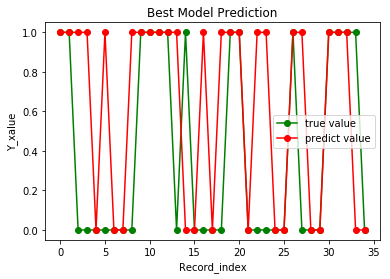

In [52]:
actual_value = [test[x, 'num'] for x in range(len(test['num']))]
actual_value = list(map(int, actual_value))
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('Best Model Prediction', pred_value, actual_value)

In [53]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.690476190476
             precision    recall  f1-score   support

          0       0.85      0.52      0.65        21
          1       0.55      0.86      0.67        14

avg / total       0.73      0.66      0.65        35



#### GBM

In [54]:
# get the GBM model
model_GBM, model_GBM_ID = get_model_by_algo('GBM', bm)
model_GBM_ID

'GBM_grid_0_AutoML_20181010_200955_model_25'

In [55]:
# write scoring_history, statistic data into file
if model_GBM is not None:
    try:     
        sh_df = model_GBM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_gbm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass
    try:
        stats_gbm = gbm_stats(model_GBM)
        gbm_stats = os.path.join(report_Path, run_id + '_gbm_stats.json')
        dict_to_json(stats_gbm,gbm_stats)
        print(stats_gbm['varimp'])
    except:
        pass

[('thal', 83.85889434814453, 1.0, 0.25655844326116206), ('cp', 54.45545959472656, 0.6493701117576379, 0.16660138497286642), ('ca', 49.24726867675781, 0.5872635104429738, 0.15066741202333456), ('thalach', 39.501956939697266, 0.47105268018086255, 0.12085254232120014), ('oldpeak', 24.8541316986084, 0.29638038864935645, 0.07603889112501708), ('exang', 23.747568130493164, 0.28318484658173415, 0.07265346339416073), ('sex', 16.400226593017578, 0.19556931581915676, 0.05017495921621342), ('slope', 15.461947441101074, 0.1843805306675044, 0.04730438191572188), ('age', 10.671540260314941, 0.12725591415516987, 0.032648579231426465), ('chol', 5.760387897491455, 0.06869143627838578, 0.017623367956955967), ('restecg', 1.5402637720108032, 0.018367327449087496, 0.004712292937205899), ('trestbps', 1.3611403703689575, 0.01623131786973142, 0.004164281644735374), ('fbs', 0.0, 0.0, 0.0)]


In [56]:
if model_GBM is not None:
    predictions_df, mod_perf = predictions_test(model_GBM,test,run_id, False)
else:
    print('No Such Model')

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [57]:
predictions_df.head(5)

predict,p0,p1
1,0.139543,0.860457
1,0.489139,0.510861
1,0.523013,0.476987
1,0.708374,0.291626
0,0.924978,0.0750224


In [58]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,0.03943028454137498,0.03550041375339545
mean,,0.5349374205590802,0.46506257944091967
maxs,,0.9644995862466046,0.960569715458625
sigma,,0.3335314454109111,0.3335314454109112
zeros,,0,0
missing,0,0,0
0,1,0.13954268067538855,0.8604573193246114
1,1,0.48913881953037486,0.5108611804696251
2,1,0.5230132425008477,0.4769867574991523


In [59]:
mod_perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13581572624656094
RMSE: 0.36853185241788927
LogLoss: 0.4186467705178935
Mean Per-Class Error: 0.1428571428571429
AUC: 0.8911564625850341
Gini: 0.7823129251700682
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5108611804696251: 


,0,1,Error,Rate
0,18.0,3.0,0.1429,(3.0/21.0)
1,2.0,12.0,0.1429,(2.0/14.0)
Total,20.0,15.0,0.1429,(5.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5108612,0.8275862,14.0
max f2,0.5108612,0.8450704,14.0
max f0point5,0.8147878,0.9,8.0
max accuracy,0.8147878,0.8571429,8.0
max precision,0.9605697,1.0,0.0
max recall,0.1038986,1.0,26.0
max specificity,0.9605697,1.0,0.0
max absolute_mcc,0.8147878,0.7205767,8.0
max min_per_class_accuracy,0.5108612,0.8571429,14.0
max mean_per_class_accuracy,0.5108612,0.8571429,14.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 46.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0285714,0.9600516,2.5,2.5,1.0,0.9605697,1.0,0.9605697,0.0714286,0.0714286,150.0,150.0
,2,0.0285714,0.9595336,0.0,2.5,0.0,0.0,1.0,0.9605697,0.0,0.0714286,-100.0,150.0
,3,0.0571429,0.9590207,2.5,2.5,1.0,0.9590460,1.0,0.9598078,0.0714286,0.1428571,150.0,150.0
,4,0.0571429,0.9585907,0.0,2.5,0.0,0.0,1.0,0.9598078,0.0,0.1428571,-100.0,150.0
,5,0.0571429,0.9581606,0.0,2.5,0.0,0.0,1.0,0.9598078,0.0,0.1428571,-100.0,150.0
,6,0.1142857,0.9545582,2.5,2.5,1.0,0.9570484,1.0,0.9584281,0.1428571,0.2857143,150.0,150.0
,7,0.1714286,0.8590770,2.5,2.5,1.0,0.9061897,1.0,0.9410153,0.1428571,0.4285714,150.0,150.0
,8,0.2,0.8379570,2.5,2.5,1.0,0.8466540,1.0,0.9275351,0.0714286,0.5,150.0,150.0
,9,0.3142857,0.6910597,1.875,2.2727273,0.75,0.7789637,0.9090909,0.8735092,0.2142857,0.7142857,87.5,127.2727273
,10,0.4,0.5622889,0.8333333,1.9642857,0.3333333,0.6531181,0.7857143,0.8262825,0.0714286,0.7857143,-16.6666667,96.4285714


This is the best model

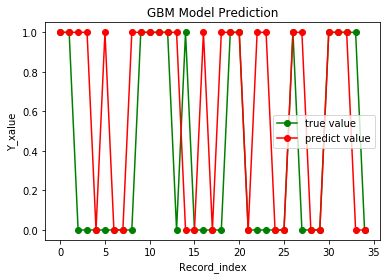

In [60]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('GBM Model Prediction', pred_value, actual_value)

In [61]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.690476190476
             precision    recall  f1-score   support

          0       0.85      0.52      0.65        21
          1       0.55      0.86      0.67        14

avg / total       0.73      0.66      0.65        35



#### DeepLearning

In [62]:
# get the DeepLearning model
model_DEE, model_DEE_ID = get_model_by_algo('Dee', bm)
model_DEE_ID

'DeepLearning_grid_0_AutoML_20181010_200955_model_0'

In [63]:
# write scoring_history, statistic data, confusion_matrix into file
if model_DEE is not None:
    try:     
        sh_df = model_DEE.scoring_history()
        sh = os.path.join(report_Path, run_id + '_dl_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_dl = dl_stats(model_DEE)
        dl_stats = os.path.join(report_Path, run_id + '_dl_stats.json')
        dict_to_json(stats_dl,dl_stats)
        print(stats_dl['varimp'])
    except:
        pass
    try:
        cf = model_DEE.confusion_matrix()    
        cf_df.to_csv(os.path.join(report_Path, run_id + '_dl_confusion_matrix.csv'))
    except:
        pass

[('sex.0', 1.0, 1.0, 0.06566732040433883), ('cp.2', 0.8607381582260132, 0.8607381582260132, 0.056522368420468094), ('ca', 0.8376100659370422, 0.8376100659370422, 0.055003608573787124), ('fbs.1', 0.8235945105552673, 0.8235945105552673, 0.054083244607887354), ('cp.3', 0.7539397478103638, 0.7539397478103638, 0.04950920298502957), ('age', 0.7446065545082092, 0.7446065545082092, 0.04889631719006136), ('exang.1', 0.6598233580589294, 0.6598233580589294, 0.0433288318639225), ('cp.1', 0.6538832187652588, 0.6538832187652588, 0.04293875883367863), ('oldpeak', 0.6387016177177429, 0.6387016177177429, 0.04194182377344056), ('slope.2', 0.6321995258331299, 0.6321995258331299, 0.04151484882235522), ('slope.3', 0.6117630004882812, 0.6117630004882812, 0.04017283696458365), ('thal.7', 0.6110304594039917, 0.6110304594039917, 0.04012473295449227), ('thal.3', 0.5967731475830078, 0.5967731475830078, 0.03918849349103915), ('chol', 0.5956671833992004, 0.5956671833992004, 0.039115867786625354), ('restecg.2', 0.5

In [64]:
if model_DEE is not None:
    predictions_df, mod_perf = predictions_test(model_DEE,test,run_id, False)
else:
    print('No Such Model')

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [65]:
predictions_df.head(5)

predict,p0,p1
1,2.75577e-23,1
1,0.0143483,0.985652
1,0.996893,0.00310724
1,0.986008,0.0139924
0,1,2.30632e-13


In [66]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,1.52352972232209e-36,7.122869501121402e-56
mean,,0.6245685437068006,0.3754314562931995
maxs,,1.0,1.0
sigma,,0.4842498359736948,0.4842498359736948
zeros,,0,0
missing,0,0,0
0,1,2.755771951511911e-23,1.0
1,1,0.014348303330339351,0.9856516966696606
2,1,0.9968927599268116,0.0031072400731885328


In [67]:
mod_perf


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1409867881525312
RMSE: 0.3754820743424794
LogLoss: 2.6798717209161356
Mean Per-Class Error: 0.13095238095238093
AUC: 0.8843537414965987
Gini: 0.7687074829931975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9856516966696606: 


,0,1,Error,Rate
0,20.0,1.0,0.0476,(1.0/21.0)
1,3.0,11.0,0.2143,(3.0/14.0)
Total,23.0,12.0,0.1143,(4.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9856517,0.8461538,4.0
max f2,0.0000000,0.8433735,19.0
max f0point5,0.9999994,0.9259259,2.0
max accuracy,0.9999994,0.8857143,2.0
max precision,1.0,1.0,0.0
max recall,0.0000000,1.0,19.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.9999994,0.7745967,2.0
max min_per_class_accuracy,0.9856517,0.7857143,4.0
max mean_per_class_accuracy,0.9856517,0.8690476,4.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 37.54 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2285714,1.0,2.5,2.5,1.0,1.0,1.0,1.0,0.5714286,0.5714286,150.0,150.0
,2,0.3142857,0.9971276,1.6666667,2.2727273,0.6666667,0.9999987,0.9090909,0.9999996,0.1428571,0.7142857,66.6666667,127.2727273
,3,0.4,0.0771149,0.8333333,1.9642857,0.3333333,0.6978855,0.7857143,0.9352609,0.0714286,0.7857143,-16.6666667,96.4285714
,4,0.5142857,0.0031072,0.0,1.5277778,0.0,0.0115640,0.6111111,0.7299949,0.0,0.7857143,-100.0,52.7777778
,5,0.6,0.0000016,0.8333333,1.4285714,0.3333333,0.0000641,0.5714286,0.6257191,0.0714286,0.8571429,-16.6666667,42.8571429
,6,0.6857143,0.0000000,0.0,1.25,0.0,0.0000000,0.5,0.5475042,0.0,0.8571429,-100.0,25.0
,7,0.8,0.0000000,1.25,1.25,0.5,0.0000000,0.5,0.4692893,0.1428571,1.0,25.0,25.0
,8,0.8857143,0.0000000,0.0,1.1290323,0.0,0.0000000,0.4516129,0.4238742,0.0,1.0,-100.0,12.9032258
,9,1.0,0.0000000,0.0,1.0,0.0,0.0000000,0.4,0.3754315,0.0,1.0,-100.0,0.0


Deep Learning model have similier max performance as GBM model, however, the threshold to be adjust is up to 0.98 out of 0.5, this is not very reasonable, which means the model is not well-trained, and it has a trend to predict one label rather than the other one.

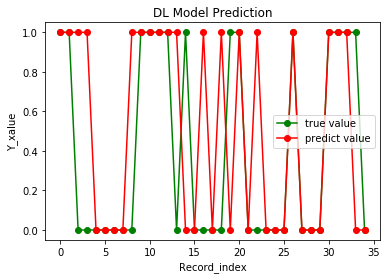

In [68]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('DL Model Prediction', pred_value, actual_value)

In [69]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.72619047619
             precision    recall  f1-score   support

          0       0.82      0.67      0.74        21
          1       0.61      0.79      0.69        14

avg / total       0.74      0.71      0.72        35



#### DRF

In [70]:
# get the DRF model
model_DRF, model_DRF_ID = get_model_by_algo('DRF', bm)
model_DRF_ID

'DRF_0_AutoML_20181010_200955'

In [71]:
# write scoring_history, statistic data into file
if model_DRF is not None:
    try:     
        sh_df = model_DRF.scoring_history()
        sh = os.path.join(report_Path, run_id + '_drf_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_drf = drf_stats(model_DRF)
        drf_stats = os.path.join(report_Path, run_id + '_drf_stats.json')
        dict_to_json(stats_drf,drf_stats)
        print(stats_drf['varimp'])
    except:
        pass

[('thal', 114.29360961914062, 1.0, 0.21232400355237932), ('cp', 104.6058349609375, 0.915237827464846, 0.19432695972991793), ('ca', 54.44884490966797, 0.4763944816434381, 0.10114998361279526), ('thalach', 48.373233795166016, 0.4232365567625314, 0.0898632801815445), ('age', 35.804901123046875, 0.31327124274365964, 0.06651500445716307), ('oldpeak', 35.27640151977539, 0.30864719066382246, 0.06553320720693734), ('trestbps', 33.01631164550781, 0.288872770363345, 0.06133462312081253), ('slope', 30.883995056152344, 0.27021628907396267, 0.05737340432125081), ('chol', 26.460186004638672, 0.23151063382118797, 0.0491552646378635), ('sex', 23.6297664642334, 0.20674617367475415, 0.043897175313759335), ('exang', 15.355476379394531, 0.13435113678326743, 0.028525971243636674), ('restecg', 12.267383575439453, 0.10733219133001333, 0.022789200573238407), ('fbs', 3.8821640014648438, 0.033966588459331516, 0.007211922048701312)]


In [72]:
if model_DRF is not None:
    predictions_df, mod_perf = predictions_test(model_DRF,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [73]:
predictions_df.head(5)

predict,p0,p1
1,0.0714286,0.928571
1,0.357143,0.642857
1,0.571429,0.428571
0,0.928571,0.0714286
0,1,0


In [74]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,0.0,0.0
mean,,0.5648979592080018,0.43510204079199805
maxs,,1.0,1.0
sigma,,0.3808019410878006,0.3808019410878006
zeros,,4,6
missing,0,0,0
0,1,0.07142857142857142,0.9285714285714286
1,1,0.35714285714285715,0.6428571428571428
2,1,0.5714285714285714,0.4285714285714286


In [75]:
mod_perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.10977259473411405
RMSE: 0.331319475331762
LogLoss: 0.34911122703958625
Mean Per-Class Error: 0.09523809523809534
AUC: 0.9115646258503401
Gini: 0.8231292517006803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6428571428571428: 


,0,1,Error,Rate
0,20.0,1.0,0.0476,(1.0/21.0)
1,2.0,12.0,0.1429,(2.0/14.0)
Total,22.0,13.0,0.0857,(3.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6428571,0.8888889,4.0
max f2,0.6428571,0.8695652,4.0
max f0point5,0.6428571,0.9090909,4.0
max accuracy,0.6428571,0.9142857,4.0
max precision,1.0,1.0,0.0
max recall,0.0714286,1.0,12.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.6428571,0.8207677,4.0
max min_per_class_accuracy,0.6428571,0.8571429,4.0
max mean_per_class_accuracy,0.6428571,0.9047619,4.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 43.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1142857,1.0,2.5,2.5,1.0,1.0,1.0,1.0,0.2857143,0.2857143,150.0,150.0
,2,0.1142857,0.9714286,0.0,2.5,0.0,0.0,1.0,1.0,0.0,0.2857143,-100.0,150.0
,3,0.2285714,0.9285714,2.5,2.5,1.0,0.9285714,1.0,0.9642857,0.2857143,0.5714286,150.0,150.0
,4,0.3142857,0.7571429,1.6666667,2.2727273,0.6666667,0.8095238,0.9090909,0.9220779,0.1428571,0.7142857,66.6666667,127.2727273
,5,0.4,0.5285714,1.6666667,2.1428571,0.6666667,0.6190476,0.8571429,0.8571429,0.1428571,0.8571429,66.6666667,114.2857143
,6,0.5142857,0.3571429,0.0,1.6666667,0.0,0.4142857,0.6666667,0.7587302,0.0,0.8571429,-100.0,66.6666667
,7,0.7142857,0.1428571,0.3571429,1.3,0.1428571,0.1836735,0.52,0.5977143,0.0714286,0.9285714,-64.2857143,30.0000000
,8,0.8285714,0.0714286,0.625,1.2068966,0.25,0.0714286,0.4827586,0.5251232,0.0714286,1.0,-37.5,20.6896552
,9,1.0,0.0,0.0,1.0,0.0,0.0,0.4,0.4351020,0.0,1.0,-100.0,0.0


Similiar performance as best model, and can be another best if focus on the threshold and accuracy.

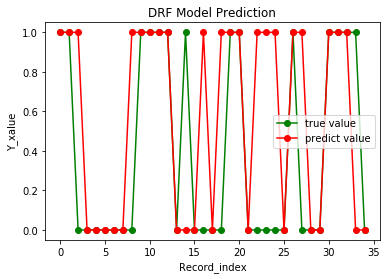

In [76]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('DRF Model Prediction', pred_value, actual_value)

In [77]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.738095238095
             precision    recall  f1-score   support

          0       0.87      0.62      0.72        21
          1       0.60      0.86      0.71        14

avg / total       0.76      0.71      0.72        35



#### XRT

In [78]:
# get the XRT model
model_XRT, model_XRT_ID = get_model_by_algo('XRT', bm)
model_XRT_ID

'XRT_0_AutoML_20181010_200955'

In [79]:
# write scoring_history, statistic data into file
if model_XRT is not None:
    try:     
        sh_df = model_XRT.scoring_history()
        sh = os.path.join(report_Path, run_id + '_xrt_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_xrt = xrt_stats(model_XRT)
        xrt_stats = os.path.join(report_Path, run_id + '_xrt_stats.json')
        dict_to_json(stats_xrt,xrt_stats)
        print(stats_xrt['varimp'])
    except:
        pass

[('cp', 74.8313980102539, 1.0, 0.16162593743556575), ('thal', 65.73507690429688, 0.8784424539989137, 0.14197908511077328), ('oldpeak', 55.81943130493164, 0.7459359679112622, 0.12056260008056383), ('thalach', 55.077056884765625, 0.736015340475379, 0.11895916937129022), ('trestbps', 34.176666259765625, 0.456715592231519, 0.07381708573585885), ('age', 34.14613723754883, 0.45630762147287285, 0.07375114707954636), ('ca', 30.01871109008789, 0.4011512799209567, 0.06483645167070168), ('exang', 27.601404190063477, 0.3688479024043002, 0.05961538799723708), ('chol', 24.169292449951172, 0.3229833077104791, 0.052202479884745974), ('slope', 24.164794921875, 0.32292320555823073, 0.05219276581804694), ('sex', 22.54981231689453, 0.30134158810990813, 0.048704616666586036), ('restecg', 11.321346282958984, 0.15129139083313206, 0.024452612869335526), ('fbs', 3.3801419734954834, 0.045170103237043804, 0.007300660279748488)]


In [80]:
if model_XRT is not None:
    predictions_df, mod_perf = predictions_test(model_XRT,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [81]:
predictions_df.head(5)

predict,p0,p1
1,0.0833333,0.916667
1,0.583333,0.416667
1,0.333333,0.666667
1,0.583333,0.416667
0,1,0


In [82]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,0.0,0.0
mean,,0.5407043650391555,0.4592956349608443
maxs,,1.0,1.0
sigma,,0.33818729441895923,0.3381872944189592
zeros,,4,4
missing,0,0,0
0,1,0.08333333333333333,0.9166666666666666
1,1,0.5833333333333334,0.41666666666666663
2,1,0.3333333333333333,0.6666666666666667


In [83]:
mod_perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.1277696793830807
RMSE: 0.3574488486246399
LogLoss: 0.3833333748399579
Mean Per-Class Error: 0.16666666666666674
AUC: 0.8962585034013606
Gini: 0.7925170068027212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7333333330849807: 


,0,1,Error,Rate
0,20.0,1.0,0.0476,(1.0/21.0)
1,4.0,10.0,0.2857,(4.0/14.0)
Total,24.0,11.0,0.1429,(5.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7333333,0.8,5.0
max f2,0.4166667,0.8552632,9.0
max f0point5,0.8333333,0.8695652,3.0
max accuracy,0.7333333,0.8571429,5.0
max precision,1.0,1.0,0.0
max recall,0.1666667,1.0,12.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.7333333,0.7035265,5.0
max min_per_class_accuracy,0.7333333,0.7142857,5.0
max mean_per_class_accuracy,0.7333333,0.8333333,5.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 45.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1142857,1.0,2.5,2.5,1.0,1.0,1.0,1.0,0.2857143,0.2857143,150.0,150.0
,2,0.1142857,0.9666667,0.0,2.5,0.0,0.0,1.0,1.0,0.0,0.2857143,-100.0,150.0
,3,0.2,0.875,2.5,2.5,1.0,0.8888889,1.0,0.9523810,0.2142857,0.5,150.0,150.0
,4,0.2,0.8416667,0.0,2.5,0.0,0.0,1.0,0.9523810,0.0,0.5,-100.0,150.0
,5,0.3142857,0.7200000,1.875,2.2727273,0.75,0.7666667,0.9090909,0.8848485,0.2142857,0.7142857,87.5,127.2727273
,6,0.4,0.4500000,0.0,1.7857143,0.0,0.5833333,0.7142857,0.8202381,0.0,0.7142857,-100.0,78.5714286
,7,0.5714286,0.4166667,1.25,1.625,0.5,0.4166667,0.65,0.6991667,0.2142857,0.9285714,25.0,62.5
,8,0.6285714,0.3333333,0.0,1.4772727,0.0,0.3333333,0.5909091,0.6659091,0.0,0.9285714,-100.0,47.7272727
,9,0.8285714,0.1666667,0.3571429,1.2068966,0.1428571,0.1785714,0.4827586,0.5482759,0.0714286,1.0,-64.2857143,20.6896552
,10,0.8857143,0.0333333,0.0,1.1290323,0.0,0.0876736,0.4516129,0.5185596,0.0,1.0,-100.0,12.9032258


Samiliar as DRF model

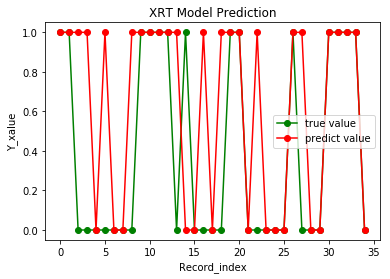

In [84]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('XRT Model Prediction', pred_value, actual_value)

In [85]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.75
             precision    recall  f1-score   support

          0       0.92      0.57      0.71        21
          1       0.59      0.93      0.72        14

avg / total       0.79      0.71      0.71        35



#### GLM

In [86]:
# get the XRT model
model_GLM, model_GLM_ID = get_model_by_algo('GLM', bm)
model_GLM_ID

'GLM_grid_0_AutoML_20181010_200955_model_0'

In [87]:
# write scoring_history, statistic data into file
if model_GLM is not None:
    try:     
        sh_df = model_GLM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_glm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_glm = glm_stats(model_GLM)
        glm_stats = os.path.join(report_Path, run_id + '_glm_stats.json')
        dict_to_json(stats_glm,glm_stats)
        print(stats_glm['varimp'])
    except:
        pass

In [88]:
if model_GLM is not None:
    predictions_df, mod_perf = predictions_test(model_GLM,test,run_id, False)
else:
    print('No Such Model')

glm prediction progress: |████████████████████████████████████████████████| 100%


In [89]:
predictions_df.head(5)

predict,p0,p1
1,0.00917384,0.990826
1,0.340785,0.659215
1,0.428348,0.571652
1,0.708143,0.291857
0,0.919348,0.0806524


In [90]:
predictions_df.describe()

Rows:35
Cols:3




,predict,p0,p1
type,enum,real,real
mins,,0.009173836979594396,0.01424348958161044
mean,,0.514009051207404,0.485990948792596
maxs,,0.9857565104183895,0.9908261630204056
sigma,,0.3838365135740396,0.38383651357403964
zeros,,0,0
missing,0,0,0
0,1,0.009173836979594396,0.9908261630204056
1,1,0.3407845169253395,0.6592154830746605
2,1,0.42834772651766584,0.5716522734823342


In [91]:
mod_perf


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.13516057302453224
RMSE: 0.36764190868905605
LogLoss: 0.41594722151721136
Null degrees of freedom: 34
Residual degrees of freedom: 9
Null deviance: 47.66781585650458
Residual deviance: 29.116305506204803
AIC: 81.11630550620481
AUC: 0.8979591836734694
Gini: 0.7959183673469388
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6592154830746605: 


,0,1,Error,Rate
0,20.0,1.0,0.0476,(1.0/21.0)
1,2.0,12.0,0.1429,(2.0/14.0)
Total,22.0,13.0,0.0857,(3.0/35.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6592155,0.8888889,12.0
max f2,0.6592155,0.8695652,12.0
max f0point5,0.9058696,0.9259259,9.0
max accuracy,0.6592155,0.9142857,12.0
max precision,0.9908262,1.0,0.0
max recall,0.0633019,1.0,29.0
max specificity,0.9908262,1.0,0.0
max absolute_mcc,0.6592155,0.8207677,12.0
max min_per_class_accuracy,0.6592155,0.8571429,12.0
max mean_per_class_accuracy,0.6592155,0.9047619,12.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 48.60 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0285714,0.9908175,2.5,2.5,1.0,0.9908262,1.0,0.9908262,0.0714286,0.0714286,150.0,150.0
,2,0.0285714,0.9908088,0.0,2.5,0.0,0.0,1.0,0.9908262,0.0,0.0714286,-100.0,150.0
,3,0.0571429,0.9907734,2.5,2.5,1.0,0.9908007,1.0,0.9908134,0.0714286,0.1428571,150.0,150.0
,4,0.0571429,0.9903103,0.0,2.5,0.0,0.0,1.0,0.9908134,0.0,0.1428571,-100.0,150.0
,5,0.0571429,0.9898472,0.0,2.5,0.0,0.0,1.0,0.9908134,0.0,0.1428571,-100.0,150.0
,6,0.1142857,0.9856439,2.5,2.5,1.0,0.9887127,1.0,0.9897631,0.1428571,0.2857143,150.0,150.0
,7,0.1714286,0.9762742,2.5,2.5,1.0,0.9795513,1.0,0.9863591,0.1428571,0.4285714,150.0,150.0
,8,0.2,0.9675285,2.5,2.5,1.0,0.9699841,1.0,0.9840198,0.0714286,0.5,150.0,150.0
,9,0.3142857,0.8399828,1.875,2.2727273,0.75,0.9273129,0.9090909,0.9633991,0.2142857,0.7142857,87.5,127.2727273
,10,0.4,0.6263921,1.6666667,2.1428571,0.6666667,0.6717299,0.8571429,0.9008986,0.1428571,0.8571429,66.6666667,114.2857143


Same problem as Deep Learning model, the threshold is unreasonable

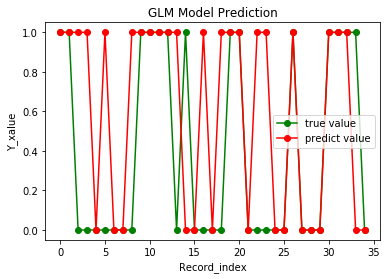

In [92]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
pred_value = list(map(int, pred_value))
plot_result('GLM Model Prediction', pred_value, actual_value)

In [93]:
clas_metrics(actual_value, pred_value)

AUC Score:  0.714285714286
             precision    recall  f1-score   support

          0       0.86      0.57      0.69        21
          1       0.57      0.86      0.69        14

avg / total       0.74      0.69      0.69        35



### 8. Clean up

#### Update and save meta data

In [94]:
meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
meta_data_path = os.path.join(run_dir, run_id + '_meta_data.json')
dict_to_json(meta_data, meta_data_path)

#### shutdown

In [96]:
os.chdir(rootDir)
h2o.cluster().shutdown()

H2O session _sid_8484 closed.
